In [1]:
#Import the neccesary python libraries for Bayesian analysis
#and data visualisation.

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import pystan as ps
import arviz as az
import statistics as Stats
import scipy.stats as stats


### https://osf.io/uszvx/ data can be dowloaded from the OSF framework. "Data_Final.csv"


In [2]:
#Use os to change working directory to import data into jupyter notebook for analysis
os.chdir("C:\\Users\\harri/OneDrive/Documents/OSF_Downloads")

#Read in csv file to dataframe
df = pd.read_csv("Turning_Hands_Data_Final.csv")

#Extrract neo mean (openess to experience) scores and Rotation conditions for comparison below
df_Mu_neo_condt = df[["mean_NEO", "Rotation"]]
df_Mu_neo_condt

,mean_NEO,Rotation
0,0.666667,counter
1,1.166667,clock
2,0.833333,counter
3,0.000000,clock
4,-0.250000,counter
...,...,...
97,0.083333,counter
98,1.000000,clock
99,1.333333,counter
100,0.333333,counter


In [3]:
#Extract counter clockwie groups neo means and converst into numpy array for vectorisation using python dictionary below.

df_counter = df_Mu_neo_condt[df_Mu_neo_condt['Rotation'].str.contains('co')]

counter = df_counter["mean_NEO"].to_numpy()


# Plotting histograms of the two groups data or expolratory check

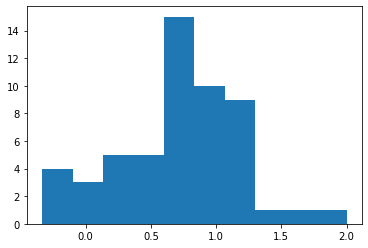

In [4]:
plt.hist(counter)
plt.show()

In [5]:
df_clock = df_Mu_neo_condt[df_Mu_neo_condt['Rotation'].str.contains('cl')]
#Extract counter clockwie groups neo means and convert into numpy array for vectorisation using python dictionary below.
clock = df_clock["mean_NEO"].to_numpy()


<function matplotlib.pyplot.show(*args, **kw)>

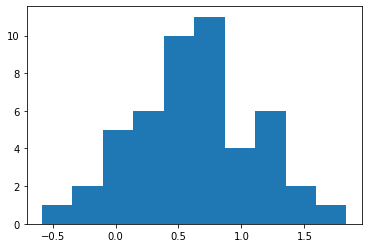

In [6]:
clock
plt.hist(clock)
plt.show

## Between subject Mean estimation in Stan. simplest model estimating just the Means and difference of two independent groups, with uniform priors bounded by the neo scale scores -2,+2. default prior on the $\sigma$ parameter.
### $$y_{1} \sim {\sf N(\mu,\sigma)}$$ $$y_{2} \sim {\sf N(\mu,\sigma)}$$$$\mu_{1,2}\sim U(-2,+2)$$$$\sigma_{1,2}\sim U(-\infty,+\infty) $$







In [7]:
#Stan model put into string to be called when the model is compiled
Model_t = """

data {
  int<lower=0> N1;  // # of observations (counter clockwise)
  int<lower=0> N2;  // # of observations (clockwise)
  vector[N1] Y1;  // Neo scores (counter clockwise)
  vector[N2] Y2;  // Neo scores (clockwise);
}

parameters {
  real<lower=-2,upper=2> mu_1;  // mean of (counter clockwise) group bounded to lower -2 and upper 2 in line with the likert
  //scale on the neo personality measure.
  real<lower=-2,upper=2> mu_2;  // mean of (clockwise) group 
  real<lower=0> sigma; // pooled standard deviation
}

model {

// likelihood
  Y1 ~ normal(mu_1, sigma);
  Y2 ~ normal(mu_2, sigma);
}

generated quantities {
  real cohen_d = (mu_2 - mu_1) / sigma; //effect size;
}

"""
#Cohen D being generated form the posterior samples 

In [8]:
#Create python dictionary to specify the data to be modelled using th stan coded model above,
#(Should provalbly use length funtion for the N vector.
Model_t_dat = {'N1': 54 ,
               'N2': 48,
               'Y1': counter,
               'Y2': clock}

#Fit the model using 2000 sample iterations and 4 chains with the 4 cores on this machine.
#If you have more you can use more if less then use less.

fit = ps.stan(model_code = Model_t, data = Model_t_dat, iter=2000, chains=4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eac8fceb5a3d5b191cfe544c89f9048e NOW.


## Stan Model fit output.

In [9]:
print(fit)

Inference for Stan model: anon_model_eac8fceb5a3d5b191cfe544c89f9048e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_1      0.72  1.1e-3   0.07   0.58   0.67   0.72   0.76   0.85   3685    1.0
mu_2      0.64  1.1e-3   0.07    0.5   0.59   0.64   0.69   0.78   3868    1.0
sigma     0.49  6.0e-4   0.03   0.43   0.47   0.49   0.51   0.56   3265    1.0
cohen_d  -0.15  3.2e-3    0.2  -0.55  -0.29  -0.15  -0.02   0.24   3987    1.0
lp__     21.55    0.03   1.26  18.27  21.01  21.87  22.45  22.96   2091    1.0

Samples were drawn using NUTS at Sat Oct 31 17:53:25 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [10]:
# The fit object outputs of the fitted model above generates 
# the point estimates from the posterior distributon based on 
# the liklihodd and the defautlt prior.

# Arviz plotting 
### Posterior density disitributions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CFAB738988>,
      dtype=object)

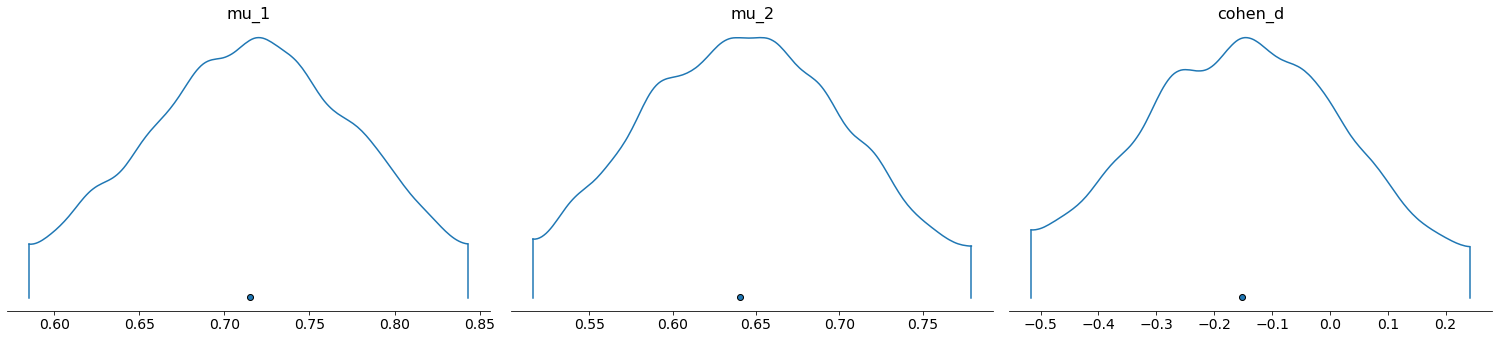

In [11]:
az.plot_density(fit, var_names=["mu_1", "mu_2","cohen_d"])

# Posterior for estimated parameters for the 4 MCMC sampling chains.
# Shows good chain mixing and exploration of parameter space.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CFAA51B588>,
      dtype=object)

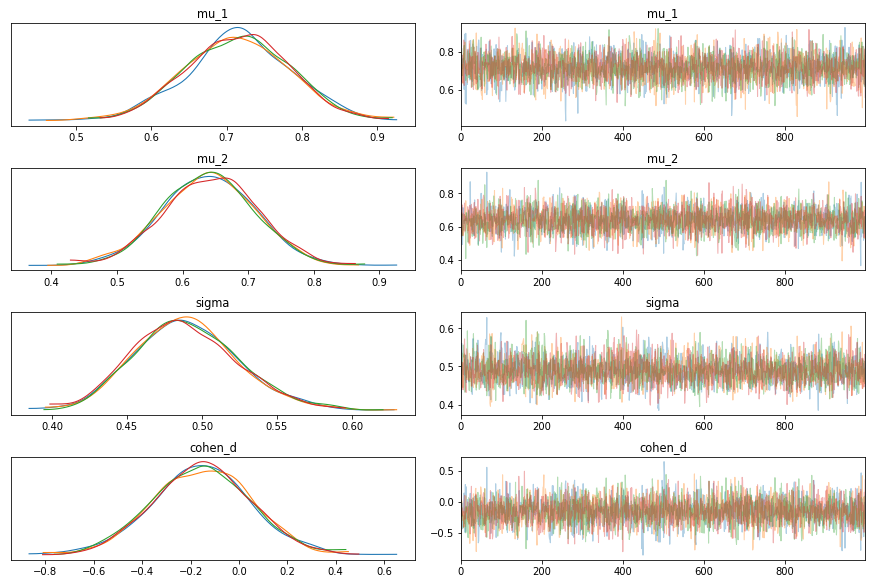

In [12]:
az.plot_trace(fit)


### The posterior plots show the  94% credible interval of the estimated posterior disitributions
### for the means, pooled standard deviations(estimated on only for the cohen d calcuation). The cohen d standardised mean d ifference if the st 
### interesting for infernces in the standard framework of decion mking of a decion of meaningful differnce
### Kruskche (2013) as while the point estimate suggests a diffenece, the credible interval spans across zero 
### so the diffence could reasonalbe be credible in either direction.

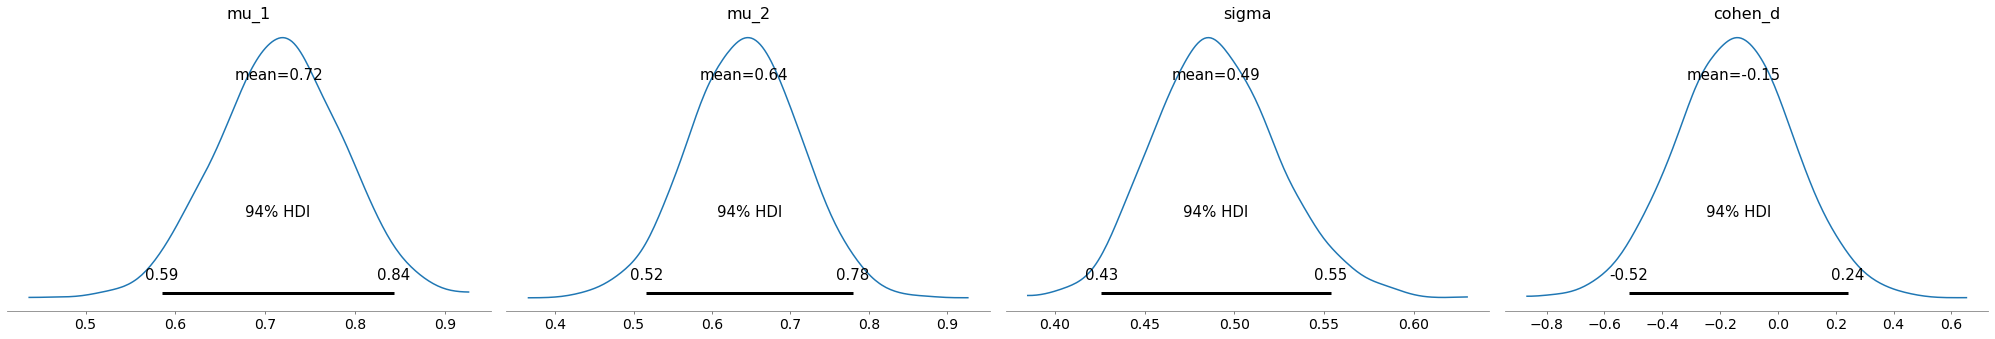

In [13]:
az.plot_posterior(fit);


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CFB1287A48>],
      dtype=object)

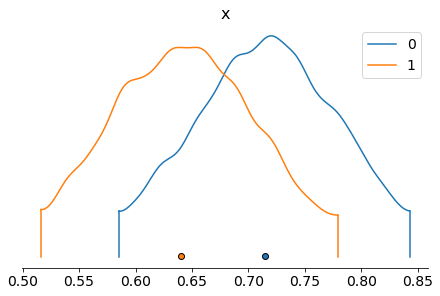

In [14]:
mean1 = fit["mu_1"]
mean2 = fit["mu_2"]
az.plot_density([mean1,mean2])